In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

## Redução de dimensionalidade
##### utilizando PCA

In [4]:

#função para aplicar PCA e plotar os pontos no 2D, sendo os eixos os dois componentes principais
def apply_and_plot_pca(df, class_column, labels):

    #filtrar o DataFrame para conter apenas as linhas com labels das duas classes desejadas
    df = df[df[class_column].isin([labels[0], labels[1]])]
    
    #armazenar os labels e remover a coluna de labels do DataFrame, para que não seja incluída no PCA
    labels_column = df[class_column]
    df = df.drop(columns=[class_column])

    #aplicar PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)

    #criar um novo DataFrame só com os dois componentes principais
    pca_df = pd.DataFrame(components, columns=['x', 'y'])
    pca_df[class_column] = labels_column.values

    #mapear os pontos de cada classe para uma cor diferente
    colors = {labels[0]: 'red', labels[1]: 'blue'}
    label_colors = labels_column.map(colors)

    #plotar o gráfico de dispersão
    plt.scatter(pca_df['x'], pca_df['y'], c=label_colors)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Dataset')

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=labels[0]),
                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label=labels[1])],
               loc='upper right')
    plt.show()

    
    return pca_df



## exemplos de datsets ja testados


* ### a string **class_column** deve ser ajustada para cada dataset, com o nome da coluna que contem a classificação;

* ### o array **labels** deve ser ajustado para cada dataset, com os nomes das duas classes;

* ### o primeiro parametro de **apply_and_plot_pca** devem ser ajustados para cada dataset, com seu nome;




In [5]:
# # Exemplo de uso com o dataset Iris
# from sklearn.datasets import load_iris
# iris = load_iris()
# iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
# iris_df['species'] = iris.target_names[iris.target]
# iris_df.head()

# # Chamar a função com o DataFrame, o nome da coluna de classe e os dois rótulos de classe
# class_column = 'species'

# labels = ['setosa', 'versicolor']

# pca_df = apply_and_plot_pca(iris_df, class_column, labels)




# Exemplo de uso com o dataset Wine

# from sklearn.datasets import load_breast_cancer

# # Carregar o dataset Wine
# wine = load_diabetes()
# df = pd.DataFrame(wine.data, columns=wine.feature_names)
# df['sex'] = df['sex'].apply(lambda x: 'male' if x > 0 else 'female')
# df.head()

# pca_df = apply_and_plot_pca( df, 'sex', 'male', 'female')
# labels = ['male', 'female']

# hull_class1, hull_class2 = divide_points(pca_df, 'sex')
# check_separability(hull_class1, hull_class2)





## IMPORTANDO O DATASET 
* #### DEFININDO A COLUNA DE CLASSIFICAÇÃO E OS LABELS
* ####  APLICANDO O PCA E PLOTANDO O GRAFICO

### MUDAR O CÓDIGO SOMENTE AQUI!!!!!!!!!!!!

In [20]:
# Exemplo de uso com o dataset Iris
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]
iris_df.head()

#MUDAR AQUI!!!!!!!!!!!
class_column = 'species'
labels = ['setosa', 'versicolor']


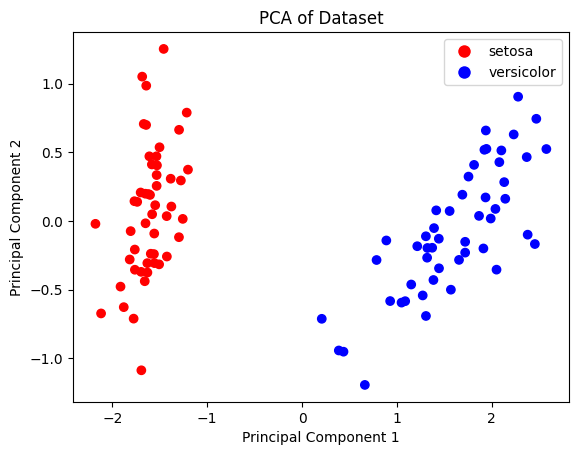

In [19]:

pca_df = apply_and_plot_pca(iris_df, class_column, labels)

### SEPARANDO O DATASET EM TREINO E TESTE

In [7]:
from sklearn.model_selection import train_test_split

# Dividindo o DataFrame em treino e teste
train_df, test_df = train_test_split(pca_df, test_size=0.3, random_state=42)

# Verificando os tamanhos dos conjuntos
print("Tamanho do conjunto de treino:", len(train_df))
print("Tamanho do conjunto de teste:", len(test_df))

print(train_df.head())





Tamanho do conjunto de treino: 70
Tamanho do conjunto de teste: 30
           x         y     species
11 -1.559477 -0.091170      setosa
47 -1.763716 -0.354586      setosa
85  1.814922  0.408481  versicolor
28 -1.603994  0.189849      setosa
93  0.437317 -0.951029  versicolor


In [8]:
print(test_df.head())

           x         y     species
83  2.456253 -0.167517  versicolor
53  1.307201 -0.691018  versicolor
70  2.144147  0.161842  versicolor
45 -1.631534 -0.374770      setosa
44 -1.203672  0.373796      setosa


# Envoltória Convexa
Computação da Envolória Convexa utilizando a Varredura de Graham

In [3]:
#função para calcular posição relativa entre pontos
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0: return 0  # colinear
    return 1 if val > 0 else 2  # horário (1) ou anti-horário (2)

#função para calcular ângulo polar entre dois pontos
def polar_angle(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return np.arctan2(y_span, x_span)

#função para calcular distância entre dois pontos
def distance(p0, p1):
    return (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2

#função para calcular a envoltória convexa de um conjunto de pontos
def graham_scan(points):
    n = len(points)

    #ponto com a coordenada y mais baixa
    ymin = min(points, key=lambda x: x[1])
    min_index = points.index(ymin)
    points[0], points[min_index] = points[min_index], points[0]  #troca o ponto inicial com o primeiro ponto

    #ordena os pontos por ângulo polar e depois por distância
    pivot = points[0]
    sorted_points = sorted(points[1:], key=lambda x: (polar_angle(pivot, x), -distance(pivot, x))) #ordena por ângulo polar e depois por distância em caso de empate

    #inicializa a pilha de pontos
    stack = [pivot, sorted_points[0], sorted_points[1]]

    #processamento
    for point in sorted_points[2:]:
        #enquanto houver mudança de direção no sentido horário, remove o último ponto da pilha
        while len(stack) > 1 and orientation(stack[-2], stack[-1], point) !=2:
            stack.pop()
        stack.append(point)
    
    return stack


# Interseção 
##### checar se as classes são linearmente separáveis, para assim poder gerar um hiperplano que as separe e classifique corretamente

In [9]:
#função para verificar se dois segmentos se interceptam
def doIntersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    return False

#função para dividir os pontos do dataset entre as duas classes
def divide_points(pca_df, class_column, labels):

    #separar os pontos de cada classe em arrays
    class1_points = pca_df[pca_df[class_column] == labels[0]][['x', 'y']].values
    class2_points = pca_df[pca_df[class_column] == labels[1]][['x', 'y']].values

    #calcular a envoltória convexa de cada classe
    hull_class1 = graham_scan(class1_points.tolist())
    hull_class2 = graham_scan(class2_points.tolist())

    return class1_points, class2_points, hull_class1, hull_class2


#função para verificar se as classes são separáveis linearmente
def check_separability(hull_class1, hull_class2):

    are_separable = True

    for i in range(len(hull_class1) - 1): #iterar sobre os pontos da envoltória convexa da classe 1

        for j in range(len(hull_class2) - 1): #iterar sobre os pontos da envoltória convexa da classe 2

            #verificar se os segmentos formados pelo ponto atual e o próximo (de cada classe) se interceptam
            if doIntersect(hull_class1[i], hull_class1[i + 1], hull_class2[j], hull_class2[j + 1]): 
                are_separable = False
                break

    #imprimir o resultado
    if are_separable:
        print("As classes são separáveis linearmente.")
    else:
        print("As classes não são separáveis linearmente.")
        



In [10]:

class1_points, class2_points, hull_class1, hull_class2 = divide_points(train_df, class_column, labels)
check_separability(hull_class1, hull_class2)


As classes são separáveis linearmente.


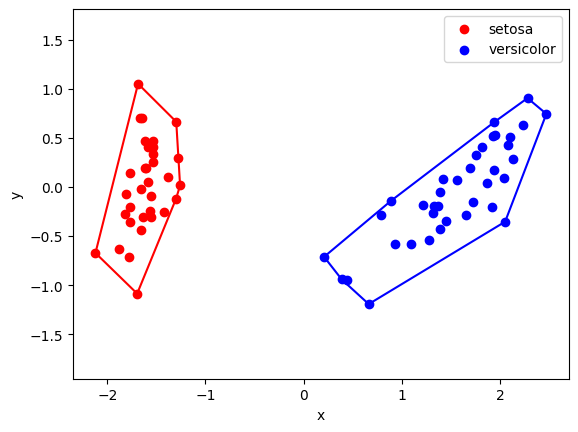

In [11]:
#plot envoltórias convexas
def plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels):
    plt.scatter(class1_points[:, 0], class1_points[:, 1], c='r', label=labels[0])
    plt.scatter(class2_points[:, 0], class2_points[:, 1], c='b', label=labels[1])

    hull_class1 = np.vstack((hull_class1, hull_class1[0]))
    hull_class2 = np.vstack((hull_class2, hull_class2[0]))

    plt.plot(hull_class1[:, 0], hull_class1[:, 1], 'r-')
    plt.plot(hull_class2[:, 0], hull_class2[:, 1], 'b-')


    plt.xlabel(pca_df.columns[0])
    plt.ylabel(pca_df.columns[1])
    plt.legend()
    plt.axis('equal')



plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels)


# Ponto mais próximo

Calcular o ponto de uma envoltória mais próximo de outra envoltória e em seguida plotar o segmento de reta entre os dois pontos

In [21]:

#função para calcular a distância euclidiana entre dois pontos
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

#função para calcular a distância de um ponto até um segmento de reta
def point_to_segment_distance(p, a, b):

    #vetorizando os pontos
    p = np.array(p)
    a = np.array(a)
    b = np.array(b)
    
    #calculando os vetores
    ap = p - a
    ab = b - a
    
    #calculando o produto escalar
    dot_product = np.dot(ap, ab) / np.dot(ab, ab)
    
    #evitando que o ponto de projeção saia do segmento de linha
    dot_product = np.clip(dot_product, 0, 1)
    
    #calculando o ponto de projeção no segmento de linha
    projection = a + dot_product * ab
    
    #retornando a distancia euclidiana entre o ponto e a projeção dele no segmento
    return euclidean_distance(p, projection), projection


def plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels):
    
    plot_hulls(hull_class1, hull_class2, class1_points, class2_points, labels)

    # Plotar a menor distância
    plt.plot(*closest_pair[0], 'go')  # ponto ou projeção na envoltória 1
    plt.plot(*closest_pair[1], 'go')  # ponto ou projeção na envoltória 2
    plt.plot([closest_pair[0][0], closest_pair[1][0]], 
            [closest_pair[0][1], closest_pair[1][1]], 'g-')  # linha representando a menor distância
    
    

#função para calcular o par de pontos mais próximos entre as duas classes, que geram o menor segmento entre as duas envoltórias convexas
def min_hulls_distance(hull_class1, hull_class2):
    
    min_distance = float('inf') #menor distância entre as envoltórias convexas, inicializada com infinito
    closest_pair = (None, None) #par de pontos mais próximos entre as duas envoltórias convexas, inicializados com None

    #distância entre pontos de cada classe
    for p1 in hull_class1:
        for p2 in hull_class2:
            distance = euclidean_distance(p1, p2)
            if distance < min_distance:
                min_distance = distance
                closest_pair = (p1, p2)

    #distância entre a projecao de cada ponto de uma classe no segmento formado por dois pontos da outra classe
    for i in range(len(hull_class1) - 1): #projecao dos pontos da classe 2 no segmento formado por dois pontos da classe 1
        for p2 in hull_class2:
            distance, projection = point_to_segment_distance(p2, hull_class1[i], hull_class1[i+1])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (projection, p2)

    for i in range(len(hull_class2) - 1): #projecao dos pontos da classe 1 no segmento formado por dois pontos da classe 2
        for p1 in hull_class1:
            distance, projection = point_to_segment_distance(p1, hull_class2[i], hull_class2[i+1])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (p1, projection)

    #ao final destes loops, o par de pontos mais próximos entre as duas envoltórias convexas estará armazenado na variável closest_pair

    return closest_pair


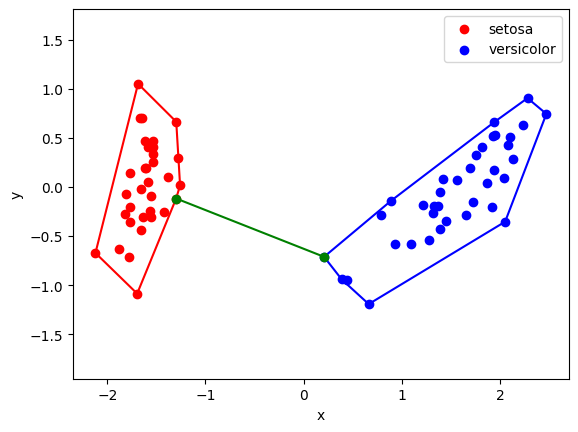

In [22]:
closest_pair = min_hulls_distance(hull_class1, hull_class2)

plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels)

# Linha perpendicular de separação

In [23]:
#função para calcular a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
def compute_perpendicular_line(p1, p2):

    #calcular a inclinação da reta que passa pelos dois pontos
    if p2[0] - p1[0] != 0:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])

        #calcular a inclinação da reta perpendicular
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = 0 #reta horizontal
    else:
        perp_slope = float('inf') #reta vertical

    #calcular o ponto médio do segmento
    midpoint = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    #calcular o coeficiente linear da reta perpendicular
    y_intercept = midpoint[1] - perp_slope * midpoint[0]

    

    #retornar a inclinação, o coeficiente linear e o ponto médio da reta perpendicular
    return perp_slope, y_intercept, midpoint

#função para plotar a reta perpendicular ao segmento formado pelos dois pontos mais próximos entre as duas envoltórias convexas
def plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels):

    plot_hulls_and_seg(hull_class1, hull_class2, closest_pair, class1_points, class2_points, labels)

    margin = 0.5 #ajustar conforme necessário

    #ajustar o tamanho da reta perpendicular para que ela seja visível no gráfico
    if abs(perp_slope) != float('inf'):
        x = np.linspace(midpoint[0] - margin, midpoint[0] + margin, 400)
        y = perp_slope * x + y_intercept
        plt.plot(x, y, 'm-')
    else:
        plt.axvline(x=midpoint[0], color='m', linestyle='-')

    #setar os limites do gráfico para que a reta perpendicular seja o foco
    plt.xlim(midpoint[0] - margin, midpoint[0] + margin)
    plt.ylim(midpoint[1] - margin, midpoint[1] + margin)

    plt.axis('equal')

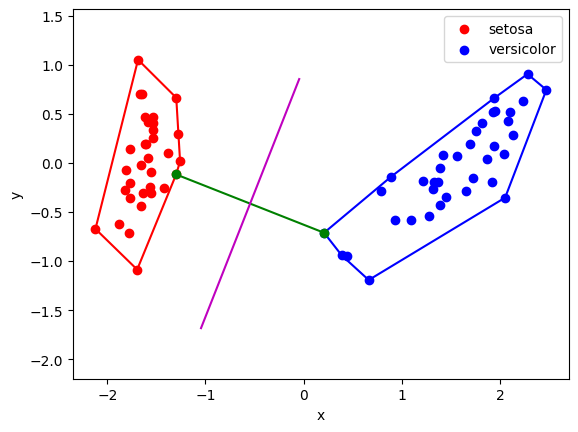

In [24]:
perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels)

## Verificar à qual classe um novo ponto pertence

In [25]:
#função para calcular a equação da reta perpendicular que passa pelo ponto médio
def perpendicular_line_equation(closest_pair):
    
    perp_slope, y_intercept, midpoint = compute_perpendicular_line(closest_pair[0], closest_pair[1])

    A = -perp_slope
    B = 1
    C = perp_slope * midpoint[0] - midpoint[1]

    line_coeficients = [A, B, C]
    return line_coeficients
    

def class_position(labels, closest_pair, line_coeficients):

    A, B, C = line_coeficients

    value = A * closest_pair[0][0] + B * closest_pair[0][1] + C
    if value > 0:
        class_above = labels[0]
        class_below = labels[1]
        return class_above, class_below
    elif value < 0:
        class_above = labels[1]
        class_below = labels[0]
        return class_above, class_below


def determine_class(class_above, class_below, point, line_coeficients):

    if len(line_coeficients) != 3:
        raise ValueError(f"Expected 3 coefficients, but got {len(line_coeficients)}: {line_coeficients}")
    A, B, C = line_coeficients

    #Determina a qual classe o ponto pertence

    value = A * point[0] + B * point[1] + C
    
    if value > 0:
        return class_above
    elif value < 0:
        return class_below
    else:
        return "on the line"
   


def plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels):
    
    plot_hulls_and_seg_and_line(hull_class1, hull_class2, closest_pair, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels)

    plt.plot(test_point[0], test_point[1], 'o', color='magenta', label='Test Point')

   
    plt.legend()
    plt.axis('equal')
    plt.show()



The test point belongs to the class: versicolor


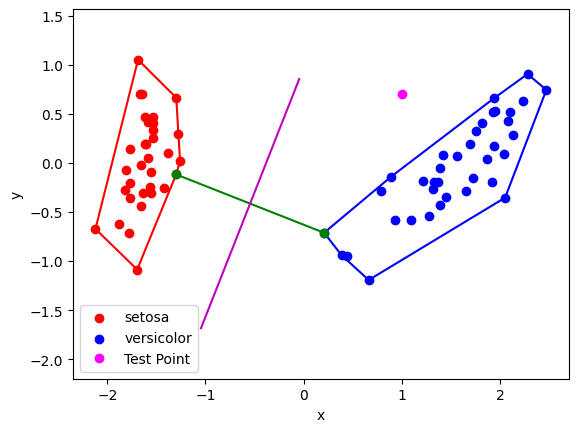

In [26]:
# Exemplo de uso:
line_coeficients = perpendicular_line_equation(closest_pair)
test_point = [1, 0.7]
class_above, class_below = class_position(labels, closest_pair, line_coeficients)
predicted_class = determine_class(class_above, class_below, test_point, line_coeficients)
print(f"The test point belongs to the class: {predicted_class}")
plot_data( hull_class1, hull_class2, closest_pair, test_point, perp_slope, y_intercept, midpoint, class1_points, class2_points, labels)



### PREDIÇÃO DE CLASSE NO TESTSET

In [16]:
line_coeficients = perpendicular_line_equation(closest_pair)
class_above, class_below = class_position(labels, closest_pair, line_coeficients)

#função para prever as classes de um conjunto de pontos, baseando na sua posição em relação à reta perpendicular
def predict_classes(df, line_coeficients, class_above, class_below):

   #Aplica a função determine_class para cada ponto do dataset e armazena o resultado na coluna 'Predicted Class'
   df['Predicted Class'] = df.apply(lambda row: determine_class(class_above, class_below, [row['x'], row['y']], line_coeficients), axis=1)
   return df

predicted_df = predict_classes(test_df, line_coeficients, class_above, class_below)

predicted_df.head()


,x,y,species,Predicted Class
83,2.456253,-0.167517,versicolor,versicolor
53,1.307201,-0.691018,versicolor,versicolor
70,2.144147,0.161842,versicolor,versicolor
45,-1.631534,-0.374770,setosa,setosa
44,-1.203672,0.373796,setosa,setosa


### MÉTRICAS

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Obter os valores verdadeiros e os valores previstos
y_true = predicted_df[class_column].values
y_pred = predicted_df['Predicted Class'].values

# Calcular precisão, recall e F1-score
precision = precision_score(y_true, y_pred, average='macro')  # 'macro' considera cada classe igualmente importante
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [18]:
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

# Obter os rótulos únicos
unique_labels = labels

# Imprimir as métricas para cada classe
for label, p, r, f1 in zip(unique_labels, precision_per_class, recall_per_class, f1_per_class):
    print(f"Class: {label}")
    print(f"Precision: {p:.4f}")
    print(f"Recall: {r:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 30)

Class: setosa
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
------------------------------
Class: versicolor
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
------------------------------
